## UMAP of the different families

Run UMAP on ArchiveII (or RNAStralign), UTR, and pri-miRNA, by embedding the sequence and structure for each RNA. Then color by family (don't use family in clustering fit)

One large square plot

**Assigned to**: Alberic

Use Ploty, and a white background

In [2]:
from rouskinhf import get_dataset

import pandas as pd
import numpy as np
import envbash
envbash.load.load_envbash('../.env')

In [2]:
def pairList2dotbracket(pair_list, len_seq):
    pair_list = np.array(pair_list).astype(int)
    dotbracket = ['.' for i in range(len_seq)]

    if len(pair_list) > 0:
        for pair in pair_list:
            dotbracket[min(pair)] = '('
            dotbracket[max(pair)] = ')'

    return ''.join(dotbracket)


def pairList2type(pair_list, len_seq):
    dotbracket = pairList2dotbracket(pair_list, len_seq)

    count = 0
    type_list = []
    for i in range(len(dotbracket)):
        if dotbracket[i] == '(':
            count += 1
            type_list.append('S')
        elif dotbracket[i] == ')':
            count -= 1
            type_list.append('S')
        else:
            if count==0:
                type_list.append('F')
            else:
                type_list.append('L')


    return ''.join(type_list)    

def dotbracket2pairList(dotbracket):
    pair_list = []
    stack = []
    for i in range(len(dotbracket)):
        if dotbracket[i] == '(':
            stack.append(i)
        elif dotbracket[i] == ')':
            pair_list.append([stack.pop(), i])

    return pair_list


def generate_random_structure(len_seq):
    isOpen = False
    count = 0
    structure = ''
    for i in range(len_seq):
        if np.random.rand() < 0.7:
            structure += '.'
        else:
            if not isOpen:
                structure += '('
                count += 1

                if np.random.rand() < 0.1:
                    isOpen = True

            else:
                structure += ')'
                count -= 1

                if count == 0:
                    isOpen = False

    return structure

generate_random_structure(100)

'(..((.(..........(....).)...)))(..((.(((...........())).).).).).((.(.)....).).....(....(.(.(....)..)'

In [3]:
max_len = 1024
fam_size = 400

# Archive II
data = get_dataset('RNAstralign')
data = pd.DataFrame(data).T
data['family'] = data['family'].str.split('_').str[0]

# UTR
data_UTR = get_dataset('utr')
data_UTR = pd.DataFrame(data_UTR).T
data_UTR['family'] = 'UTR'

# pri-miRNA
data_pri = get_dataset('pri_miRNA')
data_pri = pd.DataFrame(data_pri).T
data_pri['family'] = 'pri-miRNA'

# Random
N = 1000
data_random = pd.DataFrame(columns=['sequence', 'structure', 'family'])
for i in range(N):
    random_seq = ''.join(np.array(['A', 'C', 'G', 'U'])[np.random.randint(0, 4, np.random.randint(100, max_len))])
    # random_struct = dotbracket2pairList(''.join(np.array(['.', '(', ')'])[np.random.randint(0, 3, len(random_seq))]))
    random_struct = dotbracket2pairList(generate_random_structure(len(random_seq)))

    data_random.loc[i] = [random_seq, random_struct, 'random']


# Merge
data = pd.concat([data, data_UTR, data_pri, data_random])
# data = pd.concat([data_UTR, data_random])
data = data[data.sequence.str.len() < max_len]

# Add number of sequences per family
data['count'] = data.groupby('family')['family'].transform('count')
data = data[data['count'] >= fam_size]

data.loc[data['family'] == 'group', 'family'] = 'group_I'

# Sample 300 sequences per family
# data = data.groupby('family').apply(lambda x: x.sample(fam_size, replace=False))

# Sample 2000 sequences per family for the ones with more than 2000
data = data.groupby('family').apply(lambda x: x.sample(2000, replace=False) if len(x) > 2000 else x)

data.family.value_counts()

16S          2000
5S           2000
tRNA         2000
UTR          1373
pri-miRNA    1098
random       1000
group_I       737
SRP           445
tmRNA         400
Name: family, dtype: int64

In [4]:
RNA_data = data[['sequence', 'structure']].values

base2int = {base:i for i, base in enumerate('ACGU')}
struct2int = {struct:i for i, struct in enumerate('.()')}

baseStruct2int = {base+struct:(i*3)+j for i, base in enumerate('ACGU') for j, struct in enumerate('FLS')}

# One hot encoding of family, sequence, structure
# max_len = max([len(seq) for seq, _ in RNA_data])
embed_dim = 640
RNA_data_np = []
table_embedding = np.random.randn(len(baseStruct2int), embed_dim)
seq_embedding = np.random.randn(len(base2int), embed_dim//2)
struct_embedding = np.random.randn(len(struct2int), embed_dim//2)
for seq, struct in RNA_data:
    
    # seq_np = np.eye(len(base2int))[np.array([base2int[base] for base in seq])]
    # baseStruct_np = table_embedding[np.array([
    #                                         baseStruct2int[base+struct] for base, struct in zip(seq, pairList2type(struct, len(seq)))
    #                                           ])]


    seq_np = seq_embedding[np.array([base2int[base] for base in seq])]
    struct_np = struct_embedding[np.array([struct2int[struct] for struct in pairList2dotbracket(struct, len(seq))])]
    baseStruct_np = np.concatenate([seq_np, struct_np], axis=1)

    RNA_data_np.append(
        np.concatenate([ 
                baseStruct_np, 
                -np.ones((max_len - len(seq), embed_dim))],
                axis=0)
    )

RNA_data_np = np.array(RNA_data_np).astype(int)

In [22]:
import umap

reducer = umap.UMAP(n_neighbors=30, min_dist=0.8)

embedding = reducer.fit_transform(RNA_data_np.reshape((-1, embed_dim*max_len)))

In [23]:
import plotly.express as px
import plotly.graph_objects as go

fam2int = {fam:i for i, fam in enumerate(data.family.unique())}

fig = go.Figure()

colors = px.colors.qualitative.D3 + ['black', 'grey']
for family in ['group_I', '5S', 'tmRNA', 'SRP', 'tRNA', '16S', 'UTR', 'pri-miRNA']:
    fig.add_trace(go.Scatter(
        x=embedding[data.family == family, 0],
        y=embedding[data.family == family, 1],
        mode='markers',
        name=f'{family} ({len(data[data.family == family])})',
        marker=dict(
            size=4,
            color=colors[fam2int[family]],
            opacity=0.7
        )
    ))

fig.update_layout(
    template='plotly_white',
    title_text='UMAP projection of the ArchiveII, UTR, and pri-miRNA dataset, colored by family',
    xaxis_title_text='x',
    yaxis_title_text='y',
    width=900, height=800
)

fig.show()

In [21]:
fig.write_image('images/UMAP_families.pdf', width=900, height=800, scale=2)

In [62]:
# plot length distribution of each family, with common x axis

from plotly.subplots import make_subplots

fig = make_subplots(cols=1, rows=len(data.family.unique()), subplot_titles=data.family.unique())

for i, family in enumerate(data.family.unique()):
    fig.add_trace(go.Histogram(x=data[data.family == family].sequence.str.len(), name=family), row=i+1, col=1)

fig.update_layout(height=200*len(data.family.unique()), width=800, title_text="Length distribution of each family",
                    showlegend=False)
fig.show()

## Correlation plot per sequence

/var/folders/n5/24hrg3w10fx6hwhtzc93hlr00000gn/T/ipykernel_65637/3862195722.py:37: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(1 - similarity_matrix, method='average')  # Using 1 - similarity as distance


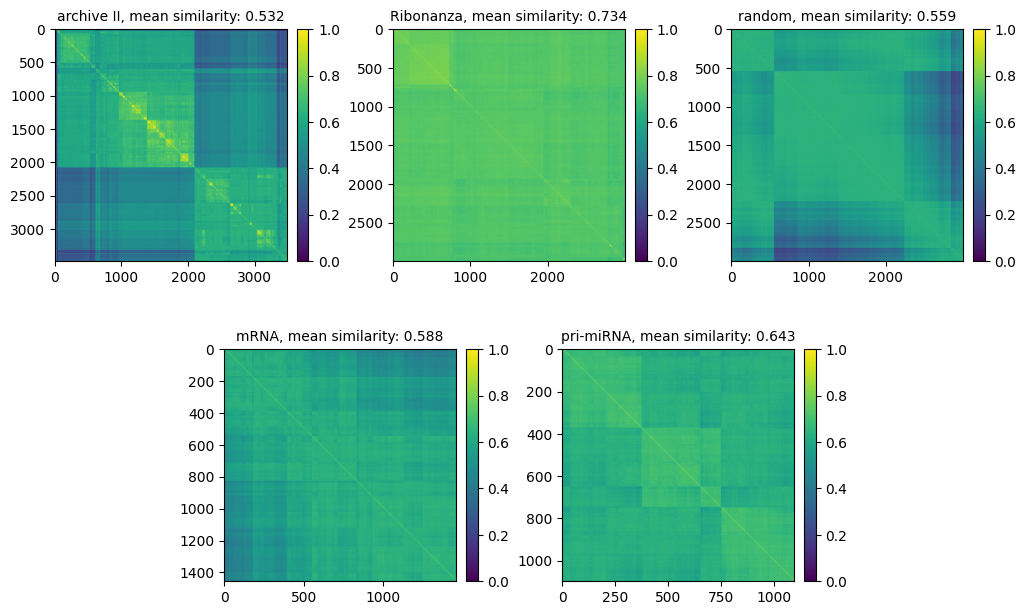

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

from sklearn.metrics.pairwise import pairwise_distances

from Levenshtein import ratio

from rouskinhf import get_dataset

def generate_random_sequences(n_sequences=1000, min_len=100, max_len=100):
    sequences = []
    for _ in range(n_sequences):
        sequence_length = np.random.randint(min_len, max_len)
        sequences.append(''.join(np.random.choice(['A', 'C', 'G', 'U'], sequence_length)))
    return np.array(sequences)

def sort_similarity(rna_sequences):

    # Function to compute similarity between two RNA sequences
    # Here we use a simple Hamming distance as a measure of dissimilarity
    # and convert it to similarity
    def rna_similarity(seq1, seq2):
        # Count the number of positions with the same nucleotide
        return ratio(seq1, seq2)

    # Create a similarity matrix for the RNA sequences
    similarity_matrix = np.zeros((len(rna_sequences), len(rna_sequences)))

    for i in range(len(rna_sequences)):
        for j in range(len(rna_sequences)):
            similarity_matrix[i, j] = rna_similarity(rna_sequences[i], rna_sequences[j])

    # Perform hierarchical clustering
    Z = linkage(1 - similarity_matrix, method='average')  # Using 1 - similarity as distance
    sorted_idx = leaves_list(Z)

    # Sort the similarity matrix
    sorted_similarity_matrix = similarity_matrix[:, sorted_idx][sorted_idx, :]

    return sorted_similarity_matrix


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

f = plt.figure(figsize=(12,12))

axes = [plt.subplot2grid((2,6), (0,0), colspan=2),
        plt.subplot2grid((2,6), (0,2), colspan=2),
        plt.subplot2grid((2,6), (0,4), colspan=2),
        plt.subplot2grid((2,6), (1,1), colspan=2),
        plt.subplot2grid((2,6), (1,3), colspan=2)]

test_sets = ['archiveII', 'ribonanza', 'random', 'human_mRNA', 'pri_miRNA']
names = {'archiveII': 'archive II', 'human_mRNA': 'mRNA', 'pri_miRNA': 'pri-miRNA', 'ribonanza': 'Ribonanza', 'random': 'random'}

for i, test_set in enumerate(test_sets):

    if test_set == 'random':
        sequences = generate_random_sequences(3000, 100, 1000)

    else:
        data = get_dataset(test_set)
        sequences = pd.DataFrame(data).T['sequence'].values

        if test_set == 'ribonanza':
            sequences = sequences[np.random.choice(len(sequences), 3000, replace=False)]
    
    # sequences = sequences[np.random.choice(len(sequences), 10, replace=False)]
    sorted_similarity = sort_similarity(sequences)

    # plt.subplot(2, 2, i+1)
    axes[i].set_title(f'{names[test_set]}, mean similarity: {sorted_similarity.mean():.3f}', fontdict={'fontsize': 10})
    im = axes[i].imshow(sorted_similarity, vmin=0, vmax=1, cmap='viridis')

    # add the colorbar
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    f.colorbar(im, cax=cax, orientation='vertical')

    plt.subplots_adjust(hspace=-0.47, wspace=1)

    

In [54]:
f.savefig("images/e_sequence_correlation.pdf", format="pdf", bbox_inches="tight")